# tutorial 03

## ABS with mask

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### read in maps

In [2]:
map30 = hp.read_map('./data/TQU_30GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map95 = hp.read_map('./data/TQU_95GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map150 = hp.read_map('./data/TQU_150GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
mapcmb = hp.read_map('./data/TQU_CMB_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
print (map95.shape, map95.dtype)

(3, 196608) float64


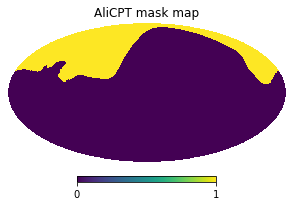

In [3]:
mask = hp.read_map('./data/ali_mask_r7.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

- PS estimation requires a built-in PS estimator (by default NaMaster)

In [4]:
est = ap.pstimator()

In [5]:
auto_cmb = est.auto_teb(mapcmb, mask, aposcale=1.0, binning=10)

auto_30 = est.auto_teb(map30, mask, aposcale=1.0, binning=10)
auto_95 = est.auto_teb(map95, mask, aposcale=1.0, binning=10)
auto_150 = est.auto_teb(map150, mask, aposcale=1.0, binning=10)
auto_353 = est.auto_teb(map353, mask, aposcale=1.0, binning=10)

cross_30_95 = est.cross_teb(np.vstack([map30,map95]), mask, aposcale=1.0, binning=10)
cross_30_150 = est.cross_teb(np.vstack([map30,map150]), mask, aposcale=1.0, binning=10)
cross_30_353 = est.cross_teb(np.vstack([map30,map353]), mask, aposcale=1.0, binning=10)

cross_95_150 = est.cross_teb(np.vstack([map95,map150]), mask, aposcale=1.0, binning=10)
cross_95_353 = est.cross_teb(np.vstack([map95,map353]), mask, aposcale=1.0, binning=10)

cross_150_353 = est.cross_teb(np.vstack([map150,map353]), mask, aposcale=1.0, binning=10)

In [6]:
Nfreq = 4  # 30,95,150,353
Llist = list(auto_cmb[0])
Nell = len(Llist)

tt_total = np.zeros((Nell,Nfreq,Nfreq))

for i in range(Nell):
    # diagnoal
    tt_total[i,0,0] = auto_30[1][i]
    tt_total[i,1,1] = auto_95[1][i]
    tt_total[i,2,2] = auto_150[1][i]
    tt_total[i,3,3] = auto_353[1][i]
    # cross
    tt_total[i,0,1] = cross_30_95[1][i]
    tt_total[i,0,2] = cross_30_150[1][i]
    tt_total[i,0,3] = cross_30_353[1][i]
    tt_total[i,1,2] = cross_95_150[1][i]
    tt_total[i,1,3] = cross_95_353[1][i]
    tt_total[i,2,3] = cross_150_353[1][i]
    tt_total[i,1,0] = tt_total[i,0,1]
    tt_total[i,2,0] = tt_total[i,0,2]
    tt_total[i,3,0] = tt_total[i,0,3]
    tt_total[i,2,1] = tt_total[i,1,2]
    tt_total[i,3,1] = tt_total[i,1,3]
    tt_total[i,3,2] = tt_total[i,2,3]

In [15]:
separator = ap.abssep(tt_total,llist=Llist,lbin=10,shift=10.,cut=1.)
rslt_tt = separator()

(1e-07, 10000000.0)

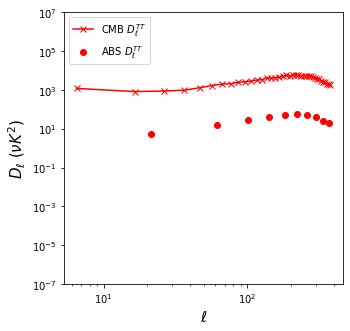

In [16]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(rslt_tt[0],rslt_tt[1],
           color='red',marker='o',label=r'ABS $D^{TT}_\ell$')

ax.plot(auto_cmb[0],(0.5/np.pi)*auto_cmb[0]*(auto_cmb[0]+1)*auto_cmb[1],
        color='red',marker='x',label=r'CMB $D^{TT}_\ell$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\nu K^2$)',fontsize=15)
ax.set_ylim((1.e-7,1.e7))

end